In [1]:
import os
import re
import torch
import torchvision
import mlflow
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

# Special imports of above dependencies:
import torchvision.transforms as T
import torch.nn as NN
import torch.nn.functional as F

# Creating subsets of UTKFace dataset

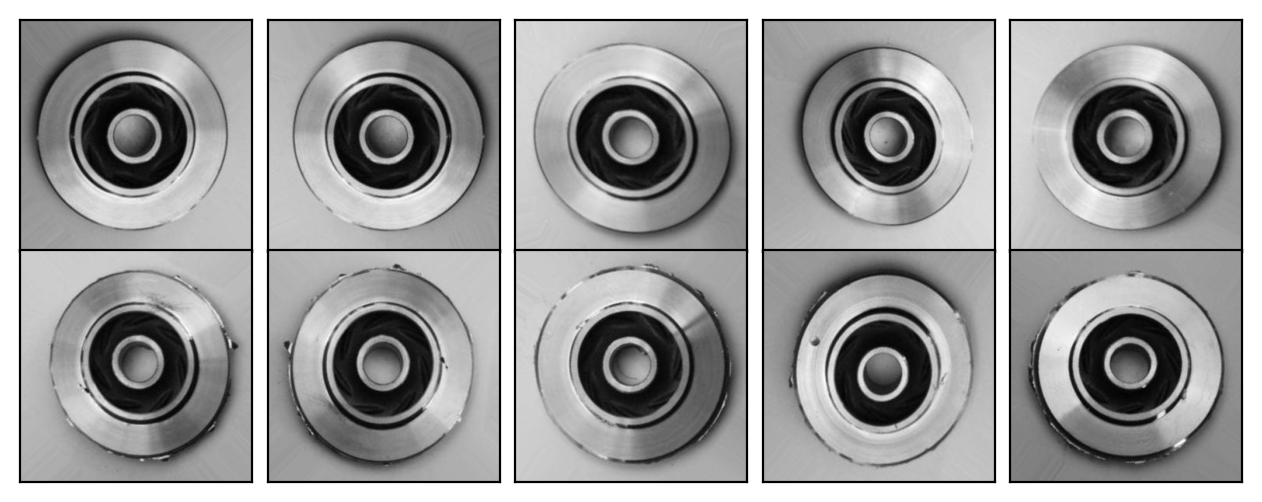

In [2]:
dataset_path_norm = "../data/raw/casting/casting_data/casting_data/train/ok_front/" # Path to GOOD images dataset
dataset_path_def  = "../data/raw/casting/casting_data/casting_data/train/def_front/" # Path to DEFECT images dataset
dataset_path_root = "../data/raw/casting/casting_data/casting_data/train/"


imgs_norm = os.listdir(os.path.join(dataset_path_norm)) # GOOD images
imgs_def  = os.listdir(os.path.join(dataset_path_def))  # DEFECT images

random.seed(42)

# Randomly sample 5 images per category:
samples_norm = random.sample(imgs_norm, 5)
samples_def  = random.sample(imgs_def, 5)

fig = plt.figure(dpi=200, figsize=(8, 3))

for i in range(len(samples_norm)):
    ax = plt.subplot(2, 5, i + 1)
    imgNormPlot = Image.open(os.path.join(dataset_path_norm, samples_norm[i]))
    plt.imshow(imgNormPlot, cmap='gray')
    plt.xticks([])
    plt.yticks([])

for i in range (len(samples_def)):
    ax = plt.subplot(2, 5, i + 6)
    imgDefPlot = Image.open(os.path.join(dataset_path_def, samples_def[i]))
    plt.imshow(imgDefPlot, cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.subplots_adjust(wspace=-0.01, hspace=-0.01)
plt.show()

# Defining the VAE architecture:

In [3]:
# Detecting if a GPU is available:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device used: {torch.cuda.get_device_name(0)}") if device == "cuda" else print("No GPU available: Using CPU")

Device used: NVIDIA GeForce RTX 5080


In [4]:
# Defining the architecture for the VAE:
class Encoder(NN.Module):
    def __init__(self, latent_dims=100):
        super().__init__()
        
        # Input: 1 x 64 x 64 (Grayscale)
        
        # Layer 1: 64 -> 32
        self.conv1 = NN.Conv2d(3, 32, 4, stride=2, padding=1) 
        self.batch1 = NN.BatchNorm2d(32)
        
        # Layer 2: 32 -> 16
        self.conv2 = NN.Conv2d(32, 64, 4, stride=2, padding=1)
        self.batch2 = NN.BatchNorm2d(64)
        
        # Layer 3: 16 -> 8
        self.conv3 = NN.Conv2d(64, 128, 4, stride=2, padding=1)
        self.batch3 = NN.BatchNorm2d(128)
        
        # Layer 4: 8 -> 4 (Cuello de botella espacial limpio)
        self.conv4 = NN.Conv2d(128, 256, 4, stride=2, padding=1)
        self.batch4 = NN.BatchNorm2d(256)
        
        # Flatten: 256 canales * 4 * 4 píxeles = 4096
        self.linear_mu = NN.Linear(256 * 4 * 4, latent_dims)
        self.linear_log_var = NN.Linear(256 * 4 * 4, latent_dims)

    def forward(self, x):
        # x shape: [batch, 1, 64, 64]
        
        x = F.relu(self.batch1(self.conv1(x))) # -> [batch, 32, 32, 32]
        x = F.relu(self.batch2(self.conv2(x))) # -> [batch, 64, 16, 16]
        x = F.relu(self.batch3(self.conv3(x))) # -> [batch, 128, 8, 8]
        x = F.relu(self.batch4(self.conv4(x))) # -> [batch, 256, 4, 4]
        
        x = torch.flatten(x, start_dim=1) # -> [batch, 4096]
        
        mu = self.linear_mu(x)
        log_var = self.linear_log_var(x)
        
        return mu, log_var

class Decoder(NN.Module):
    def __init__(self, latent_dims=100):
        super().__init__()
        
        # Proyección lineal inversa: Latente -> 4096
        self.linear = NN.Linear(latent_dims, 256 * 4 * 4)
        
        # Layer 1: 4 -> 8
        self.convT1 = NN.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.batch1 = NN.BatchNorm2d(128)
        
        # Layer 2: 8 -> 16
        self.convT2 = NN.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.batch2 = NN.BatchNorm2d(64)
        
        # Layer 3: 16 -> 32
        self.convT3 = NN.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.batch3 = NN.BatchNorm2d(32)
        
        # Layer 4: 32 -> 64 (Output Grayscale)
        self.convT4 = NN.ConvTranspose2d(32, 3, 4, stride=2, padding=1)
        
    def forward(self, z):
        # z shape: [batch, latent_dims]
        
        # Proyectar y redimensionar
        x = self.linear(z)
        x = x.view(-1, 256, 4, 4) # -> [batch, 256, 4, 4]
        
        x = F.relu(self.batch1(self.convT1(x))) # -> [batch, 128, 8, 8]
        x = F.relu(self.batch2(self.convT2(x))) # -> [batch, 64, 16, 16]
        x = F.relu(self.batch3(self.convT3(x))) # -> [batch, 32, 32, 32]
        
        # Salida final
        x = self.convT4(x) # -> [batch, 1, 64, 64]
        
        # IMPORTANTE: 
        # Usa Sigmoid si tus datos de entrada son [0, 1]
        # Usa Tanh si tus datos de entrada son [-1, 1]
        return torch.sigmoid(x) 

class VAE(NN.Module):
    def __init__(self, latent_dims=100):
        super().__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def reparametrize(self, mu, log_var):
        # Truco de reparametrización robusto
        if self.training:
            std = torch.exp(0.5 * log_var)
            # randn_like crea ruido en el mismo dispositivo (CPU/GPU) que std
            eps = torch.randn_like(std) 
            return mu + eps * std
        else:
            # En inferencia (eval), solemos usar solo la media
            return mu
    
    def forward(self, x):
        # Aseguramos que x esté en el dispositivo correcto antes de empezar
        # (Aunque idealmente x ya viene en GPU desde el dataloader)
        mu, log_var = self.encoder(x)
        z = self.reparametrize(mu, log_var)
        reconstruction = self.decoder(z)
        
        return reconstruction, mu, log_var

# Defining the training structure

In [5]:
# Define training function:
def train_epoch(beta, kl_threshold, vae_model, loader, optimizer, loss_fnc): # Ahora recibe el threshold
    vae_model.train()
    total_loss, total_recon_loss, total_kl_loss = 0, 0, 0 

    for imgs, _ in loader:
        imgs = imgs.to(device)

        recon_imgs, mu, log_var = vae_model(imgs)
        
        if loss_fnc == "MSE":
            reconstruction_loss = F.mse_loss(recon_imgs, imgs, reduction='mean') # Mean Squared Error loss
        elif loss_fnc == "BCE":
            reconstruction_loss = F.binary_cross_entropy(recon_imgs, imgs, reduction='mean') # Binary Cross Entropy Loss
        else:
            print("Loss function does not exist...")

        kl_div = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())

        kl_penalty = F.relu(kl_div - kl_threshold) # Free bits

        loss = reconstruction_loss + beta * kl_penalty
        optimizer.zero_grad()
        loss.backward() 
        NN.utils.clip_grad_norm_(vae_model.parameters(), max_norm=1.0)
        optimizer.step()

        #Acumulators:
        total_loss += loss.item() * imgs.size(0)
        total_recon_loss += reconstruction_loss.item() * imgs.size(0)
        total_kl_loss += kl_div.item() * imgs.size(0)


    avg_loss = total_loss / len(loader.dataset)
    avg_recon = total_recon_loss / len(loader.dataset)
    avg_kl = total_kl_loss / len(loader.dataset)

    return avg_loss, avg_recon, avg_kl

# Define plot function for reconstructions:
def plot_epoch(save_path=None, latent_dims=100, vae_model=None):
    vae_model.eval()
    with torch.no_grad():
        noise = torch.randn(18, latent_dims).to(device) # Generate random noise in latent space
        imgs = vae_model.decoder(noise).cpu() # Decode the noise to generate images and move to CPU
        imgs = torchvision.utils.make_grid(imgs, 6, 3).numpy() # Arrange images in a grid

        fig, ax = plt.subplots(figsize=(6,3), dpi=100)
        plt.imshow(np.transpose(imgs, (1, 2, 0)))
        plt.axis("off")

        if save_path:
            plt.savefig(save_path, bbox_inches='tight')

        plt.show()
        plt.close(fig)

# Training the VAE model

In [ ]:
# MLFlow information:
EXPERIMENT_NAME = "Defect_Generation_On_Manufactured_Pieces"
RUN_NAME = "Try: VAE for casting-metal pieces for image generation"

# Hyperparams:
HP_LR = 1e-4 # Learning rate
HP_PATIENCE = 3 # Waiting epochs for scheduler_main
HP_N_EPOCHS = 50 # Total training epochs
HP_MAX_BETA = 0.00 # Strenght of Beta-VAE regularization
HP_BATCH_SIZE = 16 # n (inputs) images per batch
HP_LATENT_DIMS = 32 # Size of latent space
HP_START_FACTOR = 0.01 # Start % of HP_LR in scheduler_warmup
HP_WEIGHT_DECAY = 1e-5 # Weight penalization for Adam Optimizer
HP_KL_THRESHOLD = 0.0 # KL Divergence threshold
HP_WARMUP_EPOCHS = 25 # Epochs to set HP_LR
HP_BETA_ANNEALING = 1 # Epochs for beta warming-up
HP_MODEL_ARCH = "Beta-VAE"
HP_LOSS_FCN = "BCE" # Loss function

In [7]:
# Transforming the data and creating batches for training:
transform = T.Compose([T.Resize((64, 64)), T.ToTensor()]) # Transforming the data into tensors of 256x256 with normalized pixels [0.0 - 1.0]
data = torchvision.datasets.ImageFolder(root=dataset_path_root, transform=transform)

data_loader = torch.utils.data.DataLoader(data, batch_size=HP_BATCH_SIZE, shuffle=True) # All classes loader

In [8]:
# Initialize VAE model and move it to the device
vae = VAE(HP_LATENT_DIMS).to(device)

# Define optimizer and schedulers:
optimizer = torch.optim.Adam(vae.parameters(), lr=HP_LR, weight_decay=HP_WEIGHT_DECAY) # Adam Optimizer
scheduler_warmup = torch.optim.lr_scheduler.LinearLR(
    optimizer,
    start_factor=HP_START_FACTOR,
    total_iters=HP_WARMUP_EPOCHS
)
scheduler_main = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    patience=HP_PATIENCE,
)

Logging parameters to MLFlow...
Starting MLFlow Run: Try: VAE for casting-metal pieces for image generation
Epoch 0 | Avg Loss: 0.7251 | Recon Loss: 0.7251 | KL Div: 0.3516 | Beta: 0.0000 | Current LR: 0.000001


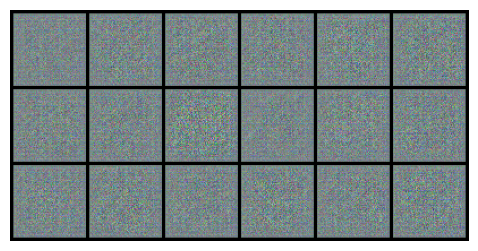

Epoch 1 | Avg Loss: 0.6785 | Recon Loss: 0.6785 | KL Div: 2.7571 | Beta: 0.0000 | Current LR: 0.000003
Epoch 2 | Avg Loss: 0.6513 | Recon Loss: 0.6513 | KL Div: 4.7901 | Beta: 0.0000 | Current LR: 0.000005
Epoch 3 | Avg Loss: 0.6323 | Recon Loss: 0.6323 | KL Div: 4.8936 | Beta: 0.0000 | Current LR: 0.000007
Epoch 4 | Avg Loss: 0.6121 | Recon Loss: 0.6121 | KL Div: 4.5255 | Beta: 0.0000 | Current LR: 0.000009
Epoch 5 | Avg Loss: 0.5991 | Recon Loss: 0.5991 | KL Div: 4.7879 | Beta: 0.0000 | Current LR: 0.000011
Epoch 6 | Avg Loss: 0.5924 | Recon Loss: 0.5924 | KL Div: 4.9606 | Beta: 0.0000 | Current LR: 0.000013
Epoch 7 | Avg Loss: 0.5883 | Recon Loss: 0.5883 | KL Div: 5.1299 | Beta: 0.0000 | Current LR: 0.000015
Epoch 8 | Avg Loss: 0.5858 | Recon Loss: 0.5858 | KL Div: 5.3714 | Beta: 0.0000 | Current LR: 0.000017
Epoch 9 | Avg Loss: 0.5840 | Recon Loss: 0.5840 | KL Div: 5.5454 | Beta: 0.0000 | Current LR: 0.000019
Epoch 10 | Avg Loss: 0.5826 | Recon Loss: 0.5826 | KL Div: 5.6726 | Beta:

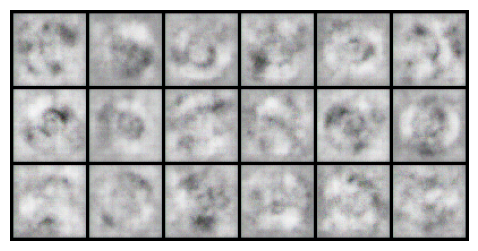

Epoch 11 | Avg Loss: 0.5815 | Recon Loss: 0.5815 | KL Div: 5.7720 | Beta: 0.0000 | Current LR: 0.000023
Epoch 12 | Avg Loss: 0.5805 | Recon Loss: 0.5805 | KL Div: 5.8514 | Beta: 0.0000 | Current LR: 0.000025
Epoch 13 | Avg Loss: 0.5796 | Recon Loss: 0.5796 | KL Div: 5.9006 | Beta: 0.0000 | Current LR: 0.000027
Epoch 14 | Avg Loss: 0.5788 | Recon Loss: 0.5788 | KL Div: 5.9375 | Beta: 0.0000 | Current LR: 0.000029
Epoch 15 | Avg Loss: 0.5781 | Recon Loss: 0.5781 | KL Div: 5.9468 | Beta: 0.0000 | Current LR: 0.000031
Epoch 16 | Avg Loss: 0.5775 | Recon Loss: 0.5775 | KL Div: 5.9365 | Beta: 0.0000 | Current LR: 0.000033
Epoch 17 | Avg Loss: 0.5769 | Recon Loss: 0.5769 | KL Div: 5.9190 | Beta: 0.0000 | Current LR: 0.000035
Epoch 18 | Avg Loss: 0.5764 | Recon Loss: 0.5764 | KL Div: 5.9045 | Beta: 0.0000 | Current LR: 0.000037
Epoch 19 | Avg Loss: 0.5759 | Recon Loss: 0.5759 | KL Div: 5.8772 | Beta: 0.0000 | Current LR: 0.000039
Epoch 20 | Avg Loss: 0.5755 | Recon Loss: 0.5755 | KL Div: 5.847

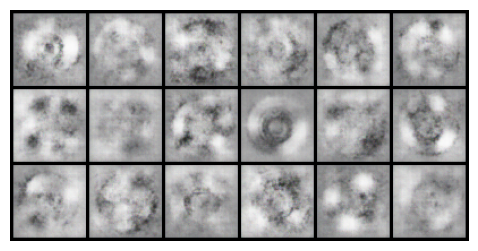

Epoch 21 | Avg Loss: 0.5752 | Recon Loss: 0.5752 | KL Div: 5.8222 | Beta: 0.0000 | Current LR: 0.000043
Epoch 22 | Avg Loss: 0.5749 | Recon Loss: 0.5749 | KL Div: 5.7563 | Beta: 0.0000 | Current LR: 0.000045
Epoch 23 | Avg Loss: 0.5746 | Recon Loss: 0.5746 | KL Div: 5.7584 | Beta: 0.0000 | Current LR: 0.000047
Epoch 24 | Avg Loss: 0.5744 | Recon Loss: 0.5744 | KL Div: 5.7305 | Beta: 0.0000 | Current LR: 0.000049
Epoch 25 | Avg Loss: 0.5742 | Recon Loss: 0.5742 | KL Div: 5.6783 | Beta: 0.0000 | Current LR: 0.000051
Epoch 26 | Avg Loss: 0.5740 | Recon Loss: 0.5740 | KL Div: 5.6432 | Beta: 0.0000 | Current LR: 0.000052
Epoch 27 | Avg Loss: 0.5739 | Recon Loss: 0.5739 | KL Div: 5.6260 | Beta: 0.0000 | Current LR: 0.000054
Epoch 28 | Avg Loss: 0.5737 | Recon Loss: 0.5737 | KL Div: 5.5655 | Beta: 0.0000 | Current LR: 0.000056
Epoch 29 | Avg Loss: 0.5736 | Recon Loss: 0.5736 | KL Div: 5.5199 | Beta: 0.0000 | Current LR: 0.000058
Epoch 30 | Avg Loss: 0.5735 | Recon Loss: 0.5735 | KL Div: 5.456

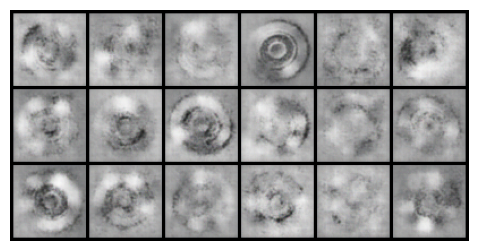

Epoch 31 | Avg Loss: 0.5734 | Recon Loss: 0.5734 | KL Div: 5.4405 | Beta: 0.0000 | Current LR: 0.000062
Epoch 32 | Avg Loss: 0.5733 | Recon Loss: 0.5733 | KL Div: 5.4025 | Beta: 0.0000 | Current LR: 0.000064
Epoch 33 | Avg Loss: 0.5732 | Recon Loss: 0.5732 | KL Div: 5.3657 | Beta: 0.0000 | Current LR: 0.000066
Epoch 34 | Avg Loss: 0.5731 | Recon Loss: 0.5731 | KL Div: 5.3194 | Beta: 0.0000 | Current LR: 0.000068
Epoch 35 | Avg Loss: 0.5730 | Recon Loss: 0.5730 | KL Div: 5.2980 | Beta: 0.0000 | Current LR: 0.000070
Epoch 36 | Avg Loss: 0.5730 | Recon Loss: 0.5730 | KL Div: 5.2269 | Beta: 0.0000 | Current LR: 0.000072
Epoch 37 | Avg Loss: 0.5729 | Recon Loss: 0.5729 | KL Div: 5.2062 | Beta: 0.0000 | Current LR: 0.000074
Epoch 38 | Avg Loss: 0.5728 | Recon Loss: 0.5728 | KL Div: 5.1596 | Beta: 0.0000 | Current LR: 0.000076
Epoch 39 | Avg Loss: 0.5728 | Recon Loss: 0.5728 | KL Div: 5.1459 | Beta: 0.0000 | Current LR: 0.000078
Epoch 40 | Avg Loss: 0.5727 | Recon Loss: 0.5727 | KL Div: 5.099

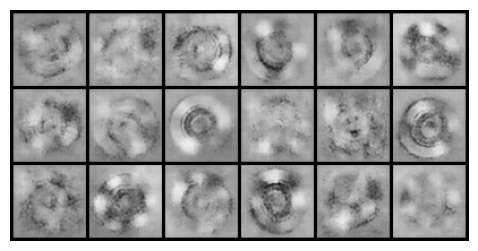

Epoch 41 | Avg Loss: 0.5727 | Recon Loss: 0.5727 | KL Div: 5.0703 | Beta: 0.0000 | Current LR: 0.000082
Epoch 42 | Avg Loss: 0.5726 | Recon Loss: 0.5726 | KL Div: 5.0303 | Beta: 0.0000 | Current LR: 0.000084
Epoch 43 | Avg Loss: 0.5726 | Recon Loss: 0.5726 | KL Div: 5.0175 | Beta: 0.0000 | Current LR: 0.000086
Epoch 44 | Avg Loss: 0.5726 | Recon Loss: 0.5726 | KL Div: 4.9841 | Beta: 0.0000 | Current LR: 0.000088
Epoch 45 | Avg Loss: 0.5725 | Recon Loss: 0.5725 | KL Div: 4.9585 | Beta: 0.0000 | Current LR: 0.000090
Epoch 46 | Avg Loss: 0.5724 | Recon Loss: 0.5724 | KL Div: 4.9189 | Beta: 0.0000 | Current LR: 0.000092
Epoch 47 | Avg Loss: 0.5724 | Recon Loss: 0.5724 | KL Div: 4.8877 | Beta: 0.0000 | Current LR: 0.000094
Epoch 48 | Avg Loss: 0.5724 | Recon Loss: 0.5724 | KL Div: 4.8570 | Beta: 0.0000 | Current LR: 0.000096
Epoch 49 | Avg Loss: 0.5724 | Recon Loss: 0.5724 | KL Div: 4.8189 | Beta: 0.0000 | Current LR: 0.000098
Epoch 50 | Avg Loss: 0.5723 | Recon Loss: 0.5723 | KL Div: 4.791

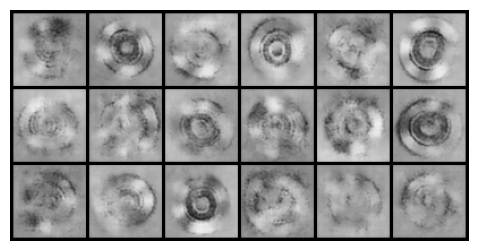

Epoch 51 | Avg Loss: 0.5723 | Recon Loss: 0.5723 | KL Div: 4.7694 | Beta: 0.0000 | Current LR: 0.000100
Epoch 52 | Avg Loss: 0.5723 | Recon Loss: 0.5723 | KL Div: 4.7428 | Beta: 0.0000 | Current LR: 0.000100
Epoch 53 | Avg Loss: 0.5722 | Recon Loss: 0.5722 | KL Div: 4.7210 | Beta: 0.0000 | Current LR: 0.000100
Epoch 54 | Avg Loss: 0.5722 | Recon Loss: 0.5722 | KL Div: 4.7064 | Beta: 0.0000 | Current LR: 0.000100
Epoch 55 | Avg Loss: 0.5722 | Recon Loss: 0.5722 | KL Div: 4.6782 | Beta: 0.0000 | Current LR: 0.000100
Epoch 56 | Avg Loss: 0.5721 | Recon Loss: 0.5721 | KL Div: 4.6472 | Beta: 0.0000 | Current LR: 0.000100
Epoch 57 | Avg Loss: 0.5721 | Recon Loss: 0.5721 | KL Div: 4.6245 | Beta: 0.0000 | Current LR: 0.000100
Epoch 58 | Avg Loss: 0.5721 | Recon Loss: 0.5721 | KL Div: 4.5875 | Beta: 0.0000 | Current LR: 0.000100
Epoch 59 | Avg Loss: 0.5721 | Recon Loss: 0.5721 | KL Div: 4.5865 | Beta: 0.0000 | Current LR: 0.000100
Epoch 60 | Avg Loss: 0.5720 | Recon Loss: 0.5720 | KL Div: 4.577

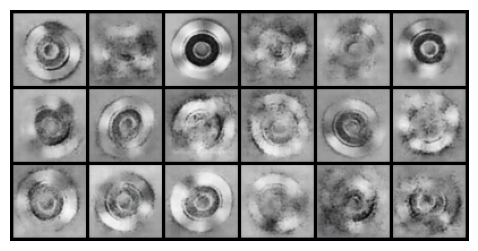

Epoch 61 | Avg Loss: 0.5720 | Recon Loss: 0.5720 | KL Div: 4.5452 | Beta: 0.0000 | Current LR: 0.000100
Epoch 62 | Avg Loss: 0.5721 | Recon Loss: 0.5721 | KL Div: 4.5219 | Beta: 0.0000 | Current LR: 0.000100
Epoch 63 | Avg Loss: 0.5720 | Recon Loss: 0.5720 | KL Div: 4.5128 | Beta: 0.0000 | Current LR: 0.000100
Epoch 64 | Avg Loss: 0.5720 | Recon Loss: 0.5720 | KL Div: 4.5005 | Beta: 0.0000 | Current LR: 0.000100
Epoch 65 | Avg Loss: 0.5720 | Recon Loss: 0.5720 | KL Div: 4.4894 | Beta: 0.0000 | Current LR: 0.000100
Epoch 66 | Avg Loss: 0.5719 | Recon Loss: 0.5719 | KL Div: 4.4769 | Beta: 0.0000 | Current LR: 0.000100
Epoch 67 | Avg Loss: 0.5719 | Recon Loss: 0.5719 | KL Div: 4.4558 | Beta: 0.0000 | Current LR: 0.000100
Epoch 68 | Avg Loss: 0.5716 | Recon Loss: 0.5716 | KL Div: 4.4778 | Beta: 0.0000 | Current LR: 0.000010
Epoch 69 | Avg Loss: 0.5715 | Recon Loss: 0.5715 | KL Div: 4.4753 | Beta: 0.0000 | Current LR: 0.000010
Epoch 70 | Avg Loss: 0.5715 | Recon Loss: 0.5715 | KL Div: 4.478

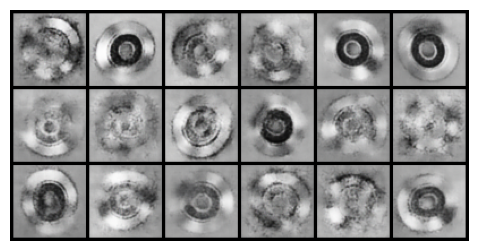

Epoch 71 | Avg Loss: 0.5715 | Recon Loss: 0.5715 | KL Div: 4.4773 | Beta: 0.0000 | Current LR: 0.000010
Epoch 72 | Avg Loss: 0.5715 | Recon Loss: 0.5715 | KL Div: 4.4803 | Beta: 0.0000 | Current LR: 0.000010
Epoch 73 | Avg Loss: 0.5715 | Recon Loss: 0.5715 | KL Div: 4.4846 | Beta: 0.0000 | Current LR: 0.000010
Epoch 74 | Avg Loss: 0.5715 | Recon Loss: 0.5715 | KL Div: 4.4885 | Beta: 0.0000 | Current LR: 0.000010
Epoch 75 | Avg Loss: 0.5714 | Recon Loss: 0.5714 | KL Div: 4.4863 | Beta: 0.0000 | Current LR: 0.000001
Epoch 76 | Avg Loss: 0.5714 | Recon Loss: 0.5714 | KL Div: 4.4883 | Beta: 0.0000 | Current LR: 0.000001
Epoch 77 | Avg Loss: 0.5714 | Recon Loss: 0.5714 | KL Div: 4.4898 | Beta: 0.0000 | Current LR: 0.000001
Epoch 78 | Avg Loss: 0.5714 | Recon Loss: 0.5714 | KL Div: 4.4909 | Beta: 0.0000 | Current LR: 0.000001
Epoch 79 | Avg Loss: 0.5714 | Recon Loss: 0.5714 | KL Div: 4.4922 | Beta: 0.0000 | Current LR: 0.000001
Epoch 80 | Avg Loss: 0.5714 | Recon Loss: 0.5714 | KL Div: 4.491

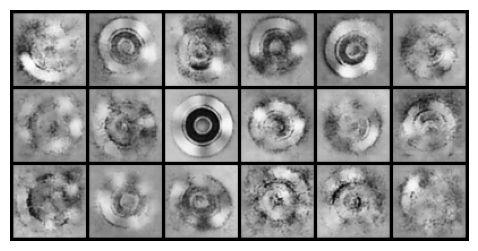

Epoch 81 | Avg Loss: 0.5714 | Recon Loss: 0.5714 | KL Div: 4.4919 | Beta: 0.0000 | Current LR: 0.000000
Epoch 82 | Avg Loss: 0.5714 | Recon Loss: 0.5714 | KL Div: 4.4919 | Beta: 0.0000 | Current LR: 0.000000
Epoch 83 | Avg Loss: 0.5714 | Recon Loss: 0.5714 | KL Div: 4.4918 | Beta: 0.0000 | Current LR: 0.000000
Epoch 84 | Avg Loss: 0.5714 | Recon Loss: 0.5714 | KL Div: 4.4920 | Beta: 0.0000 | Current LR: 0.000000
Epoch 85 | Avg Loss: 0.5714 | Recon Loss: 0.5714 | KL Div: 4.4922 | Beta: 0.0000 | Current LR: 0.000000
Epoch 86 | Avg Loss: 0.5714 | Recon Loss: 0.5714 | KL Div: 4.4921 | Beta: 0.0000 | Current LR: 0.000000
Epoch 87 | Avg Loss: 0.5714 | Recon Loss: 0.5714 | KL Div: 4.4922 | Beta: 0.0000 | Current LR: 0.000000
Epoch 88 | Avg Loss: 0.5714 | Recon Loss: 0.5714 | KL Div: 4.4923 | Beta: 0.0000 | Current LR: 0.000000
Epoch 89 | Avg Loss: 0.5714 | Recon Loss: 0.5714 | KL Div: 4.4923 | Beta: 0.0000 | Current LR: 0.000000
Epoch 90 | Avg Loss: 0.5714 | Recon Loss: 0.5714 | KL Div: 4.492

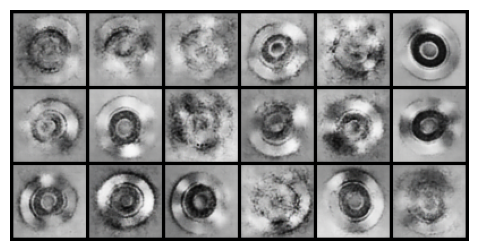

Epoch 91 | Avg Loss: 0.5714 | Recon Loss: 0.5714 | KL Div: 4.4921 | Beta: 0.0000 | Current LR: 0.000000
Epoch 92 | Avg Loss: 0.5714 | Recon Loss: 0.5714 | KL Div: 4.4923 | Beta: 0.0000 | Current LR: 0.000000
Epoch 93 | Avg Loss: 0.5714 | Recon Loss: 0.5714 | KL Div: 4.4923 | Beta: 0.0000 | Current LR: 0.000000
Epoch 94 | Avg Loss: 0.5714 | Recon Loss: 0.5714 | KL Div: 4.4923 | Beta: 0.0000 | Current LR: 0.000000
Epoch 95 | Avg Loss: 0.5714 | Recon Loss: 0.5714 | KL Div: 4.4925 | Beta: 0.0000 | Current LR: 0.000000
Epoch 96 | Avg Loss: 0.5714 | Recon Loss: 0.5714 | KL Div: 4.4925 | Beta: 0.0000 | Current LR: 0.000000
Epoch 97 | Avg Loss: 0.5714 | Recon Loss: 0.5714 | KL Div: 4.4924 | Beta: 0.0000 | Current LR: 0.000000
Epoch 98 | Avg Loss: 0.5714 | Recon Loss: 0.5714 | KL Div: 4.4924 | Beta: 0.0000 | Current LR: 0.000000
Epoch 99 | Avg Loss: 0.5714 | Recon Loss: 0.5714 | KL Div: 4.4926 | Beta: 0.0000 | Current LR: 0.000000


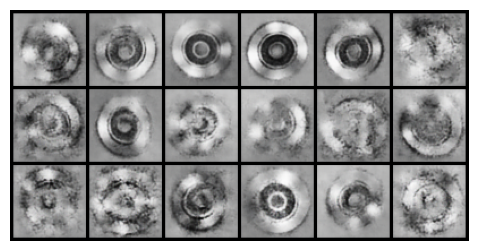

Training completed. Saving model...


In [9]:
# ==========================================================================
# ####### MODEL TRAINING (EXCECUTE ONLY IF RE-TRAINING IS NECESSARY) #######
# ==========================================================================

MLFLOW_TRACKING = True # Recording in MLFlow

if MLFLOW_TRACKING:
      
      mlflow.set_experiment(EXPERIMENT_NAME)

      with mlflow.start_run(run_name=RUN_NAME):
            print("Logging parameters to MLFlow...")
            mlflow.log_param('learning_rate', HP_LR)
            mlflow.log_param('patience', HP_PATIENCE)
            mlflow.log_param('n_epochs', HP_N_EPOCHS)
            mlflow.log_param('max_beta', HP_MAX_BETA)
            mlflow.log_param('batch_size', HP_BATCH_SIZE)
            mlflow.log_param('latent_dims', HP_LATENT_DIMS)
            mlflow.log_param('start_factor', HP_START_FACTOR)
            mlflow.log_param('weight_decay', HP_WEIGHT_DECAY)
            mlflow.log_param('kl_threshold', HP_KL_THRESHOLD)
            mlflow.log_param('warmup_epochs', HP_WARMUP_EPOCHS)
            mlflow.log_param('beta_annealing', HP_BETA_ANNEALING)
            mlflow.log_param('architecture', HP_MODEL_ARCH)
            mlflow.log_param('loss_function', HP_LOSS_FCN)
            mlflow.log_param('optimizer', "Adam")
            mlflow.log_param('scheduler', "ReduceLROnPlateau")

            print(f"Starting MLFlow Run: {mlflow.active_run().info.run_name}")

            for epoch in range(HP_N_EPOCHS):
                beta = HP_MAX_BETA * min(1.0, (epoch / HP_BETA_ANNEALING)) # Strength of KL regularization for Beta-VAE model
                avg_loss, avg_recon, avg_kl = train_epoch(beta, HP_KL_THRESHOLD, vae, data_loader, optimizer, HP_LOSS_FCN)
                current_lr = optimizer.param_groups[0]['lr'] # Current learning rate on optimizer

                print(f"Epoch {epoch} | Avg Loss: {avg_loss:.4f} | Recon Loss: {avg_recon:.4f} | KL Div: {avg_kl:.4f} | Beta: {beta:.4f} | Current LR: {current_lr:.6f}")

                mlflow.log_metric('avg_loss', avg_loss, step=epoch)
                mlflow.log_metric('recon_loss', avg_recon, step=epoch)
                mlflow.log_metric('kl_div', avg_kl, step=epoch)
                mlflow.log_metric('learning_rate', current_lr, step=epoch)

                if epoch < HP_WARMUP_EPOCHS:
                      # Warm-up phase
                      scheduler_warmup.step()
                else:
                      # After-Warm-up phase:
                      scheduler_main.step(avg_loss)

                if epoch % 10 == 0 or epoch == HP_N_EPOCHS - 1:
                        
                        # Save the image:
                        plots_filename = f"../reports/figures/vae/epoch_{epoch}.png"

                        # Call plot function:
                        plot_epoch(save_path=plots_filename, latent_dims=HP_LATENT_DIMS, vae_model=vae)

                        mlflow.log_artifact(plots_filename, "plots") # Record on MLFlow
                        os.remove(plots_filename) # Remove temporal image from repo

            # Saving the trained model:
            print("Training completed. Saving model...")
            model_filename = "../models/vae_UTKFace.pth"
            torch.save(vae.state_dict(), model_filename)
            mlflow.log_artifact(model_filename, 'model')

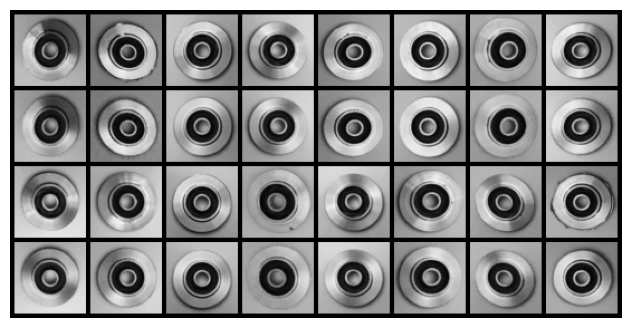

In [10]:
# Generating images using the trained model:
vae.eval()

with torch.no_grad():
    vae.load_state_dict(torch.load("../models/vae_UTKFace.pth", map_location=device))
    imgs, _ = next(iter(data_loader)) # Get a batch of images
    imgs = imgs.to(device)
    recon_imgs, mu, log_var = vae(imgs) # Forward pass through VAE

    # Concatenate the original and reconstructed images:
    images = torch.cat([
        imgs[:8].detach().cpu(),
        recon_imgs[:8].detach().cpu(),
        imgs[8:16].detach().cpu(),
        recon_imgs[8:16].detach().cpu()
    ], dim=0)

    images = torchvision.utils.make_grid(images, 8, 4)
    fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
    plt.imshow(np.transpose(images.numpy(), (1, 2, 0)))
    plt.axis("off")

    # Save image reconstruction:
    img_recon_path = f"../reports/figures/vae/vae_reconstruction.png"
    plt.savefig(img_recon_path, bbox_inches='tight')
    plt.show()

# Encoding Arithmetic with VAE